# Mini-projet Image : Tomographie

5GMM N - Nicolas Dublé, Valentin Fouqueau, Elizabeth Fu, Simon Treillou

ressources : 

https://scikit-image.org/docs/stable/api/skimage.transform.html?highlight=rotation

https://scikit-image.org/docs/0.7.0/api/skimage.transform.radon_transform.html

https://scikit-image.org/docs/dev/auto_examples/transform/plot_radon_transform.html

In [20]:
import matplotlib.pyplot as plt
import numpy as np
#import param
#import panel as pn

from skimage.data import shepp_logan_phantom
from skimage.transform import radon, iradon, rescale, rotate
from skimage.metrics import peak_signal_noise_ratio as psnr
from scipy import fftpack as ft

## Image test : fantôme de Shepp-Logan

Représentative d'une IRM d'une section abdominale.

160 160
0.0 1.0


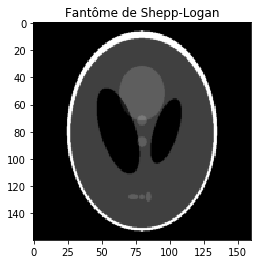

In [47]:
img = shepp_logan_phantom()
img = rescale(img, scale=0.4, mode='reflect', multichannel=False)
L,C = np.shape(img)
print(L,C)
print(np.min(img), np.max(img))

plt.imshow(img, cmap=plt.cm.Greys_r)
plt.title('Fantôme de Shepp-Logan')
plt.show()

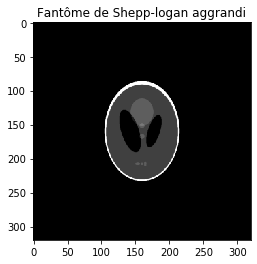

In [3]:
def zero_padding(image):
    M,N = image.shape
    res = np.zeros((M*2,N*2))
    res[int(M/2):int(M*3/2),int(N/2):int(N*3/2)] = np.copy(image)
    return res

imgz = zero_padding(img)
plt.imshow(imgz, cmap=plt.cm.Greys_r)
plt.title('Fantôme de Shepp-logan aggrandi')
plt.show()

## Mission 1 : obtenir le sinogramme

In [4]:
def radon_transform(img, theta_list):
    R = np.zeros((np.shape(img)[0] , len(theta_list)))
    # rotation de l'image pour chaque angle
    for ind in range(len(theta_list)):
        img_rot = rotate(img, -theta_list[ind])
        R[:,ind] = sum(img_rot)
    return R

# skimage.transform.rotate() :
# interpolation spline
# paramètre optionnel : 'order' pour ordre des splines (entre 0 et 5)

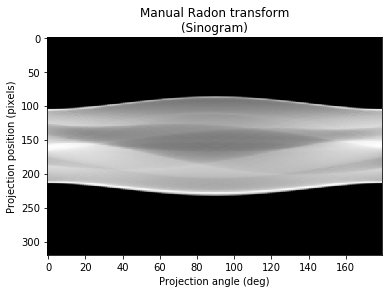

In [5]:
# test
theta_list = np.arange(180)
our_sinogram = radon_transform(imgz, theta_list)

plt.imshow(our_sinogram, cmap=plt.cm.Greys_r, aspect='auto')
plt.title("Manual Radon transform\n(Sinogram)")
plt.xlabel("Projection angle (deg)")
plt.ylabel("Projection position (pixels)")
plt.show()

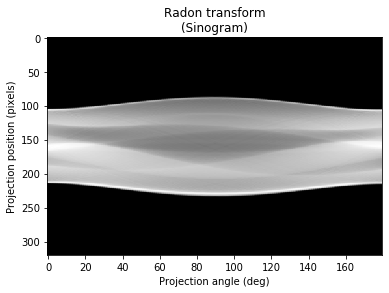

In [6]:
### vérification avec le sinogramme obtenu par radon()
sinogram_radon = radon(imgz, theta=theta_list, circle=True)

plt.imshow(sinogram_radon, cmap=plt.cm.Greys_r, aspect='auto')
plt.title("Radon transform\n(Sinogram)")
plt.xlabel("Projection angle (deg)")
plt.ylabel("Projection position (pixels)")
plt.show()

## Mission 2 : reconstruire l'image à partir du sinogramme

#### • Méthode 1 : rétroprojection filtrée

#### • Méthode 2 : itératives par projection (ART)

#### • Méthode 3 : formulation variationnelle

Les 3 méthodes n'ont pas les même défauts. L'efficacité des méthodes 1 et 2 dépendant du nombre de direction (angles).

On va comparer les images reconstruites avec l'image de référence à l'aide du PSNR. Le PSNR est un bon indicateur de reconstruction car notre image de base a beaucoup de contraste.

On rappelle que la valeur max du PSNR est 100. Plus la valeur du PSNR est grande, plus l'image reconstruite est fidèle à l'image de référence.

In [101]:
## fct pour remettre les valeurs de l'image entre 0 et 1
def normalize_img(img_test):
    img_test += np.abs(np.min(img_test))
    range_values = np.abs(np.max(img_test) - np.min(img_test))
    return img_test/range_values

0.0 1.0


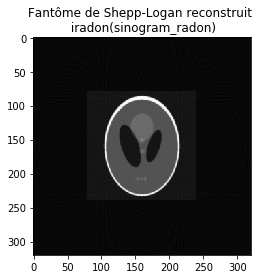

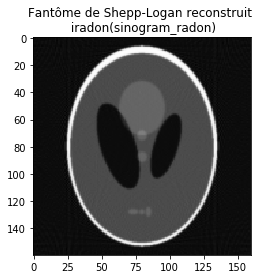

PSNR de référence :  25.842779006434323


In [102]:
### CE QU'ON SOUHAITE AVOIR :
### avec iradon()
iradon_sinogram_radon = iradon(sinogram_radon)
## crop image
crop_iradon_sinogram_radon = normalize_img(iradon_sinogram_radon[int(L/2):L+int(L/2),int(C/2):C+int(C/2)])
print(np.min(crop_iradon_sinogram_radon), np.max(crop_iradon_sinogram_radon))

plt.imshow(iradon_sinogram_radon, cmap=plt.cm.Greys_r)
plt.title('Fantôme de Shepp-Logan reconstruit \n iradon(sinogram_radon)')
plt.show()

plt.imshow(crop_iradon_sinogram_radon, cmap=plt.cm.Greys_r)
plt.title('Fantôme de Shepp-Logan reconstruit \n iradon(sinogram_radon)')
plt.show()

print("PSNR de référence : ", psnr(img, crop_iradon_sinogram_radon)) #img true, img_test

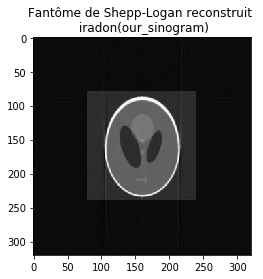

PSNR :  17.322866557986053


In [103]:
iradon_our_sinogram = iradon(our_sinogram)
crop_iradon_our_sinogram = normalize_img(iradon_our_sinogram[int(L/2):L+int(L/2),int(C/2):C+int(C/2)])

plt.imshow(iradon_our_sinogram, cmap=plt.cm.Greys_r)
plt.title('Fantôme de Shepp-Logan reconstruit \n iradon(our_sinogram)')
plt.show()

print("PSNR : ", psnr(img, crop_iradon_our_sinogram)) #img true, img_test

___
Commentaire : Ici on calcule le PSNR pour deux images reconstruites avec iradon() :
- une image dont le sinogramme a été calculé par skimage.transform.radon()
- une image dont le sinogramme a été calculé par nous

On voit qu'on perd presque 10 pts de PSNR avec notre sinogramme. On va voir si les méthodes de reconstruction (rétroprojection non-filtrée / filtrée, ART, variationnelle) permettent de regagner ces 10 pts.
___


In [104]:
def retroprojection_non_filtree(sinogram, theta_list):
    L,A = np.shape(sinogram) #320,160
    temp = np.zeros((L,L,A)) #320,320,160
    img_rec = np.zeros((L,L)) #320,320
    for index_angle in range(A):
        #print("angle numéro :", index_angle)
        tempp = np.zeros((L, L))
        # sélection de la colonne
        col = sinogram[:,index_angle]
        for index_line in range(len(col)):
            #print("valeur à copier :", col[index_line])
            tempp[index_line,:] = np.repeat(col[index_line],L)
            #print(tempp[index_line,:])
        temp[:,:,index_angle] = rotate(tempp, theta_list[index_angle])
        #plt.imshow(temp[:,:,index_angle], cmap=plt.cm.Greys_r)
        #plt.title('Fantôme de Shepp-Logan reconstruit \n rétroprojection non filtrée')
        #plt.show()
        img_rec += temp[:,:,index_angle]
    
    #return img_rec
    return normalize_img(rotate(img_rec, 90))

0.0 1.0


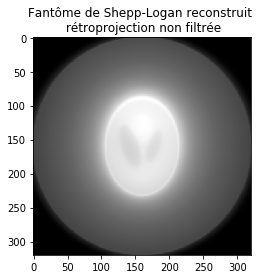

PSNR :  4.766616258346363


In [105]:
### test
our_img_rec = retroprojection_non_filtree(our_sinogram, theta_list)
print(np.min(our_img_rec), np.max(our_img_rec))

crop_our_img_rec = our_img_rec[int(L/2):L+int(L/2),int(C/2):C+int(C/2)]

plt.imshow(our_img_rec, cmap=plt.cm.Greys_r)
plt.title('Fantôme de Shepp-Logan reconstruit \n rétroprojection non filtrée')
plt.show()

print("PSNR : ", psnr(img, crop_our_img_rec)) #img true, img_test

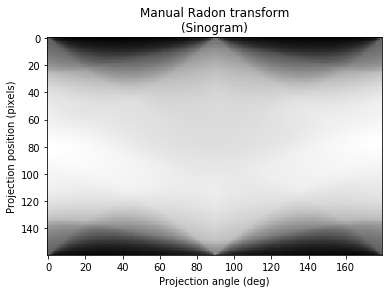

In [106]:
## sinogramme de l'image reconstruite 

sino_retro_nonfilt = radon_transform(crop_our_img_rec, theta_list)

plt.imshow(sino_retro_nonfilt, cmap=plt.cm.Greys_r, aspect='auto')
plt.title("Manual Radon transform\n(Sinogram)")
plt.xlabel("Projection angle (deg)")
plt.ylabel("Projection position (pixels)")
plt.show()

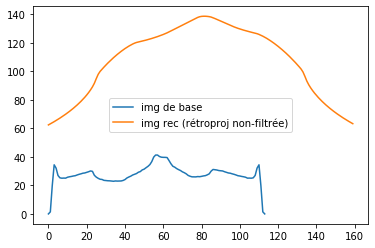

In [107]:
plt.plot(our_sinogram[our_sinogram[:,0]>0,0], label = "img de base")
plt.plot(sino_retro_nonfilt[sino_retro_nonfilt[:,0]>0,0], label = "img rec (rétroproj non-filtrée)")
plt.legend()
plt.show()

### Test variation d'ordre d'interpolation 

Au dessus, l'ordre d'interpolation par défaut est 1 car on a ue image en niveaux de gris. Testons l'interpolation à l'ordre 0, 2, 3.

Pour un grand nombre d'angles, on ne verra pas forcément la différence entre les interpolations.
Testons les différentes interpolations sur un faible nombre d'angles.

In [108]:
theta_list_interpol = np.arange(0,180,4)
print(len(theta_list_interpol))
our_sinogram2 = radon_transform(imgz, theta_list_interpol)

45


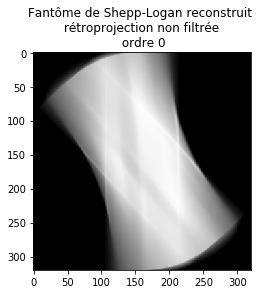

PSNR :  3.992055540454401


In [109]:
## ordre 0
def retroprojection_non_filtree(sinogram, theta_list_interpol):
    L,A = np.shape(sinogram) #320,160
    temp = np.zeros((L,L,A)) #320,320,160
    img_rec = np.zeros((L,L)) #320,320
    for index_angle in range(A):
        #print("angle numéro :", index_angle)
        tempp = np.zeros((L, L))
        # sélection de la colonne
        col = sinogram[:,index_angle]
        for index_line in range(len(col)):
            #print("valeur à copier :", col[index_line])
            tempp[index_line,:] = np.repeat(col[index_line],L)
            #print(tempp[index_line,:])
        temp[:,:,index_angle] = rotate(tempp, theta_list[index_angle], order = 1)
        #plt.imshow(temp[:,:,index_angle], cmap=plt.cm.Greys_r)
        #plt.title('Fantôme de Shepp-Logan reconstruit \n rétroprojection non filtrée')
        #plt.show()
        img_rec += temp[:,:,index_angle]
    
    #return img_rec
    return normalize_img_values(rotate(img_rec, 90))

### test
our_img_rec_order0 = retroprojection_non_filtree(our_sinogram2, theta_list)
crop_our_img_rec0 = our_img_rec_order0[int(L/2):L+int(L/2),int(C/2):C+int(C/2)]

plt.imshow(our_img_rec_order0, cmap=plt.cm.Greys_r)
plt.title('Fantôme de Shepp-Logan reconstruit \n rétroprojection non filtrée \n ordre 0')
plt.show()

print("PSNR : ", psnr(img, crop_our_img_rec0)) #img true, img_test

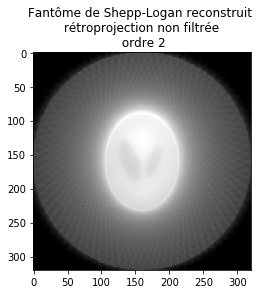

PSNR :  4.791613398299733


In [83]:
## ordre 2
def retroprojection_non_filtree(sinogram, theta_list):
    L,A = np.shape(sinogram) #320,160
    temp = np.zeros((L,L,A)) #320,320,160
    img_rec = np.zeros((L,L)) #320,320
    for index_angle in range(A):
        #print("angle numéro :", index_angle)
        tempp = np.zeros((L, L))
        # sélection de la colonne
        col = sinogram[:,index_angle]
        for index_line in range(len(col)):
            #print("valeur à copier :", col[index_line])
            tempp[index_line,:] = np.repeat(col[index_line],L)
            #print(tempp[index_line,:])
        temp[:,:,index_angle] = rotate(tempp, theta_list[index_angle], order = 2)
        #plt.imshow(temp[:,:,index_angle], cmap=plt.cm.Greys_r)
        #plt.title('Fantôme de Shepp-Logan reconstruit \n rétroprojection non filtrée')
        #plt.show()
        img_rec += temp[:,:,index_angle]
    
    #return img_rec
    return normalize_img_values(rotate(img_rec, 90))

### test
our_img_rec_order2 = retroprojection_non_filtree(our_sinogram2, theta_list_interpol)
crop_our_img_rec2 = our_img_rec_order2[int(L/2):L+int(L/2),int(C/2):C+int(C/2)]

plt.imshow(our_img_rec_order2, cmap=plt.cm.Greys_r)
plt.title('Fantôme de Shepp-Logan reconstruit \n rétroprojection non filtrée \n ordre 2')
plt.show()
print("PSNR : ", psnr(img, crop_our_img_rec2)) #img true, img_test

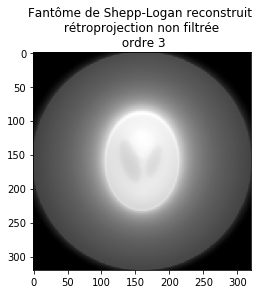

PSNR :  4.7820851964632345


In [110]:
## ordre 3
def retroprojection_non_filtree(sinogram, theta_list):
    L,A = np.shape(sinogram) #320,160
    temp = np.zeros((L,L,A)) #320,320,160
    img_rec = np.zeros((L,L)) #320,320
    for index_angle in range(A):
        #print("angle numéro :", index_angle)
        tempp = np.zeros((L, L))
        # sélection de la colonne
        col = sinogram[:,index_angle]
        for index_line in range(len(col)):
            #print("valeur à copier :", col[index_line])
            tempp[index_line,:] = np.repeat(col[index_line],L)
            #print(tempp[index_line,:])
        temp[:,:,index_angle] = rotate(tempp, theta_list[index_angle], order = 3)
        #plt.imshow(temp[:,:,index_angle], cmap=plt.cm.Greys_r)
        #plt.title('Fantôme de Shepp-Logan reconstruit \n rétroprojection non filtrée')
        #plt.show()
        img_rec += temp[:,:,index_angle]
    
    #return img_rec
    return normalize_img_values(rotate(img_rec, 90))

### test
our_img_rec_order3 = retroprojection_non_filtree(our_sinogram, theta_list)
crop_our_img_rec3 = our_img_rec_order3[int(L/2):L+int(L/2),int(C/2):C+int(C/2)]

plt.imshow(our_img_rec_order3, cmap=plt.cm.Greys_r)
plt.title('Fantôme de Shepp-Logan reconstruit \n rétroprojection non filtrée \n ordre 3')
plt.show()
print("PSNR : ", psnr(img, crop_our_img_rec3)) #img true, img_test

___
Commentaire :

Le problème de la rétroprojection non-filtrée est de créer un halo autour du fantôme de Shepp-Logan qui pollue l'image. On voit que la valeur du PSNR est très basse à cause du halo...
La simple rétroprojection n'est définitivement pas une bonne méthode de reconstruction.

Pour un faible nombre d'angles, on voit la différence entre les différentes méthodes d'interpolation. Ici, pour 45 angles, l'interpolation par nearest-neighbour ne permet pas du tout de reconstruire l'image fidèlement. Avec bilinéaire et bicubique on obtient une meilleure approximation que l'ordre 1, mais la valeur n'augmente pas non plus beaucoup car le halo est toujours créé...
___

### Rétroprojection filtrée

On définit une opération de filtrage. Cette opération va filtrer chaque projection du sinogramme pour enlever les hautes fréquences. Pour cela, on passe par la transformée de Fourier 1D sur chaque projection (donc 1D) et on multiplie par le filtre pour avoir notre convolution. On effectue ensuite une transformée de Fourier inverse et on n'a plus qu'à rétro-projeter comme précédemment.

On propose ici deux filtres : un filtre rampe simple et un filtre rampe adouci.

Figures sympas à mettre éventuellement ici : http://www.guillemet.org/irene/coursem/APRAMENrecon.pdf

In [111]:
def filtrage(sinogram,filtre,theta_list):
    T,A = sinogram.shape #Taille image, nb d'angles
    res = sinogram*0.
    for j in range(A): #colonnes = angles
        four = ft.fft(sinogram[:,j])
        res[:,j] = np.real(ft.ifft(four*filtre(T)))
    return res

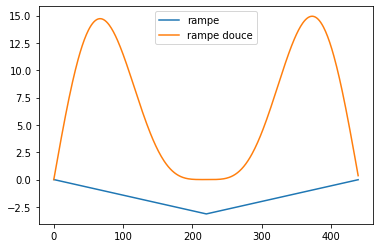

In [112]:
def rampe(T,a=1): ## pas bonne je crois
    step = 2*np.pi/T
    w = np.arange(-np.pi,np.pi,step)
    r = abs(w)
    filt = ft.fftshift(r)
    return filt

plt.plot(-rampe(440), label="rampe")

def rampe_adoucie(T, a=5):
    step = 2*np.pi/T
    w = np.arange(-np.pi, np.pi, step)
    rn1 = abs(w)  # filtre rampe
    rn2 = a*np.hanning(T)  #sinc window with 'a' modifying the cutoff freqs
    r = rn1*(rn2)**2             #modulation of ramp filter with sinc window
    filt = ft.fftshift(r) 
    return filt

plt.plot(rampe_adoucie(440), label="rampe douce")

plt.legend()
plt.show()

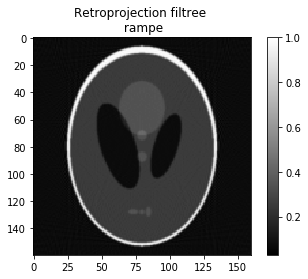

PSNR :  23.055215013525814


In [113]:
sinoFilt = filtrage(our_sinogram,rampe,theta_list)
imrec_rampe = retroprojection_non_filtree(sinoFilt, theta_list)
L,C = np.shape(img)
crop_imrec_rampe = imrec_rampe[int(L/2):L+int(L/2),int(C/2):C+int(C/2)]

plt.imshow(crop_imrec_rampe,cmap='gray')
plt.title("Retroprojection filtree \n rampe")
plt.colorbar()
plt.show()

print("PSNR : ", psnr(img, crop_imrec_rampe)) #img true, img_test

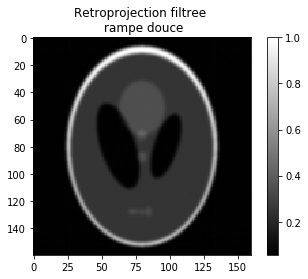

PSNR :  21.261056888694018


In [114]:
sinoFilt = filtrage(our_sinogram,rampe_adoucie,theta_list)
imrec_rampedouce = retroprojection_non_filtree(sinoFilt, theta_list)
crop_imrec_rampedouce = imrec_rampedouce[int(L/2):L+int(L/2),int(C/2):C+int(C/2)]

plt.imshow(crop_imrec_rampedouce,cmap='gray')
plt.title("Retroprojection filtree \n rampe douce")
plt.colorbar()
plt.show()

print("PSNR : ", psnr(img, crop_imrec_rampedouce)) #img true, img_test

___
Commentaire :


___

In [ ]:
## Méthode 2 : ITÉRATIVES PAR PROJECTION

In [ ]:
## Méthode 3 : FORMULATION VARIATIONNELLE